# Mining Segmentation Training Example (PyTorch)

This notebook demonstrates how to train and evaluate the UNet model for mining segmentation using PyTorch.

**Key Features:**
- Lazy-loaded dataset from Zarr (memory efficient)
- PyTorch-based training loop
- GPU/CPU device selection
- TensorBoard logging


## Setup

In [1]:
!module load CUDA/13.0.0

import sys
from pathlib import Path

# Add src to path
sys.path.insert(0, str(Path.cwd().parent))

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from network.unet import build_unet
from network.train import MiningSegmentationTrainer
from network.evaluate import MiningSegmentationEvaluator
from network.config import NetworkConfig
from network.data_loader import MiningSegmentationDataLoader

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

PyTorch version: 2.10.0+cu130
CUDA available: True
GPU: NVIDIA A100-SXM4-40GB


## 1. Explore Available Data

In [3]:
# Initialize data loader to get statistics
# (We'll create actual dataset with filters later)
temp_loader = MiningSegmentationDataLoader()

# Get statistics
stats = temp_loader.get_statistics()

print(f"Total tiles available: {stats['total_tiles']}")
print(f"Number of bands: {stats['num_bands']}")
print(f"\nCountries: {stats['countries']}")
print(f"\nYears: {stats['years']}")
print(f"\nClusters: {stats['clusters']}")


2026-02-07 14:32:18,201 - network.data_loader - INFO - Using Zarr backend: /scicore/home/meiera/schulz0022/projects/mining-net/data/landsat_zarr/data.zarr
2026-02-07 14:32:18,436 - network.data_loader - INFO - Using index arrays from Zarr group
2026-02-07 14:32:18,790 - network.data_loader - INFO - Built tile list from 43023 index entries
2026-02-07 14:32:18,806 - network.data_loader - INFO - Loaded 43023 tiles matching filters
2026-02-07 14:32:18,806 - network.data_loader - INFO - Computing normalization statistics from 100 samples...
2026-02-07 14:32:21,604 - network.data_loader - INFO - Computed: means=['0.0535', '0.0883', '0.1257', '0.2249', '0.2854', '0.2177', '288.2865'], stds=['0.0203', '0.0328', '0.0553', '0.0677', '0.0961', '0.0869', '70.6743']
2026-02-07 14:32:21,606 - network.data_loader - INFO - Initialized Zarr dataset with 43023 tiles
2026-02-07 14:32:21,607 - network.data_loader - INFO -   Features: shape=(43023, 7, 64, 64), chunks=(8, 7, 64, 64)
2026-02-07 14:32:21,608 

Total tiles available: 43023
Number of bands: 7

Countries: {'UNKNOWN': 43023}

Years: {2019: 43023}

Clusters: {6155687546600015: 72, 16714675725600725: 169, 17315396644879081: 110, 52652953960301590: 100, 62084203559214856: 63, 71137107360758801: 208, 77491409989930463: 110, 89022526743908725: 121, 101534883284040649: 121, 130239313423728009: 744, 153188716851427413: 132, 176191065995097590: 81, 244620288433317774: 110, 275433596250697125: 120, 298031492466564885: 64, 306125387993476299: 90, 308171068471083253: 144, 320860650556975719: 64, 322565366526356651: 144, 324992323012957678: 525, 327936123962620193: 81, 383509191624975320: 132, 409414307775276276: 64, 423163890930745083: 90, 423707532182137338: 81, 454913375666274587: 288, 474582821099989246: 110, 490904813412796749: 81, 492632919775126331: 64, 496918485536127517: 150, 534862203375179488: 110, 539463802049000380: 72, 560473390967562828: 64, 590679775012718885: 64, 607142139734947415: 64, 617357886029016770: 64, 6200246181852

## 2. Load and Visualize Sample Data

In [4]:
# Create dataset with a specific year
dataset = MiningSegmentationDataLoader(years=[2019], normalize=False)
print(f"Tiles for 2019: {len(dataset)}")


2026-02-07 14:32:34,003 - network.data_loader - INFO - Using Zarr backend: /scicore/home/meiera/schulz0022/projects/mining-net/data/landsat_zarr/data.zarr
2026-02-07 14:32:34,013 - network.data_loader - INFO - Using index arrays from Zarr group
2026-02-07 14:32:34,140 - network.data_loader - INFO - Built tile list from 43023 index entries
2026-02-07 14:32:34,144 - network.data_loader - INFO - Filtered to 43023 tiles by years: [2019]
2026-02-07 14:32:34,158 - network.data_loader - INFO - Loaded 43023 tiles matching filters
2026-02-07 14:32:34,159 - network.data_loader - INFO - Initialized Zarr dataset with 43023 tiles
2026-02-07 14:32:34,160 - network.data_loader - INFO -   Features: shape=(43023, 7, 64, 64), chunks=(8, 7, 64, 64)
2026-02-07 14:32:34,160 - network.data_loader - INFO -   Labels: shape=(43023, 1, 64, 64), chunks=(8, 1, 64, 64)
2026-02-07 14:32:34,161 - network.data_loader - INFO -   Normalization enabled: False (precomputed: False)


Tiles for 2019: 43023


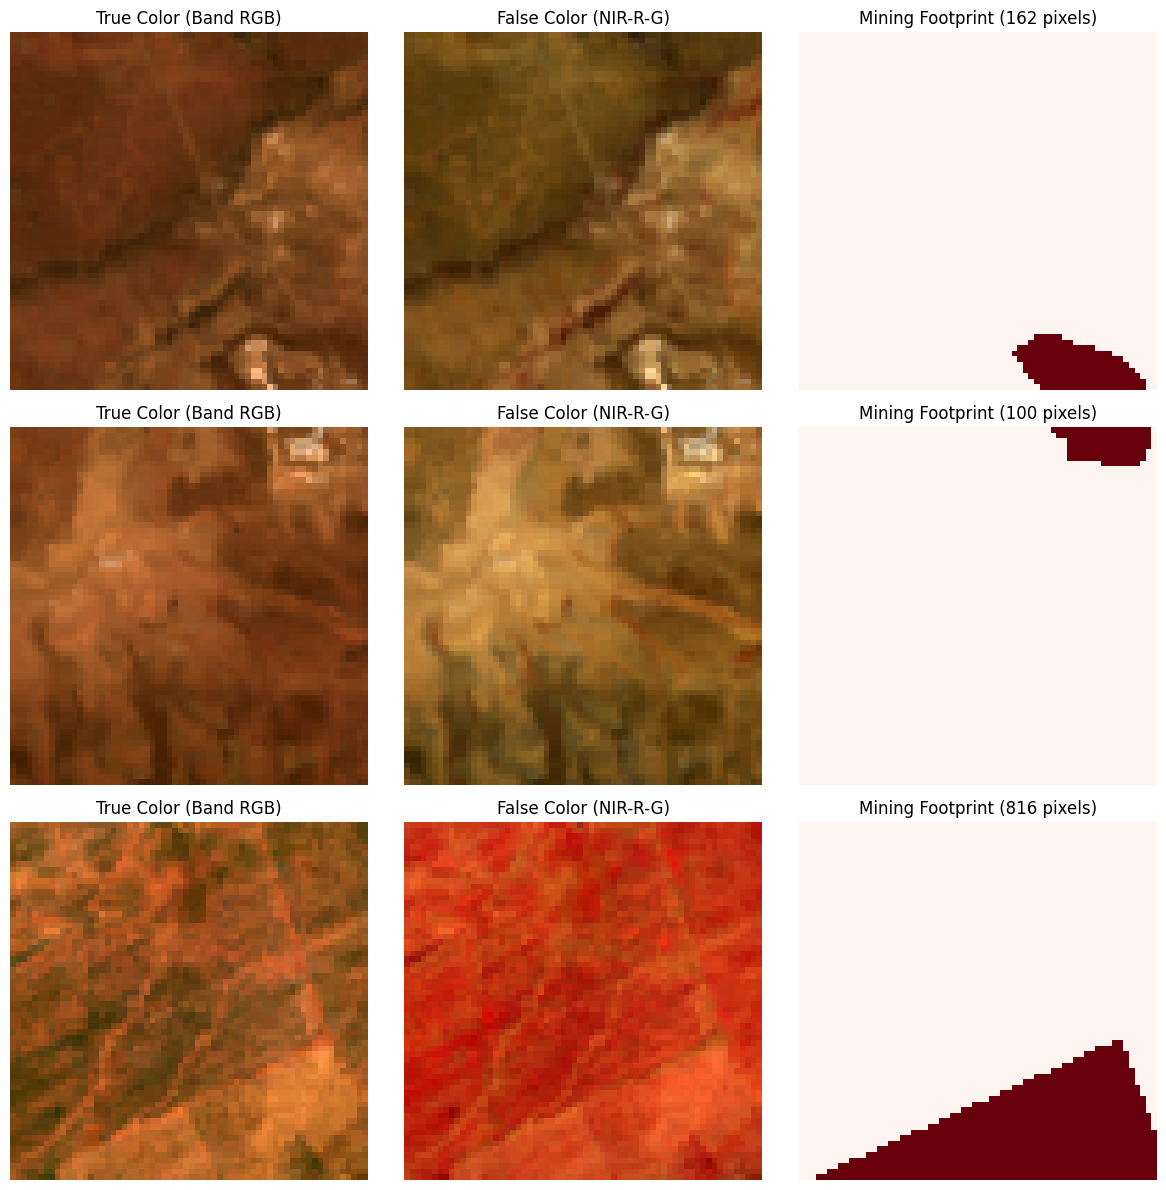

In [5]:
# Get some sample tiles from the dataset
num_samples = min(3, len(dataset))

fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
if num_samples == 1:
    axes = axes[np.newaxis, :]

i = 0
idx = 0
while i < num_samples:
    # Load tile from dataset (returns torch tensors in C,H,W format)
    features_tensor, labels_tensor = dataset[idx]
    
    # Convert to numpy and transpose to H,W,C for visualization
    features = features_tensor.permute(1, 2, 0).numpy()  # (C,H,W) -> (H,W,C)
    labels = labels_tensor.squeeze().numpy()  # (1,H,W) -> (H,W)

    if labels.sum() == 0:
        idx += 1
        continue
    
    # True color RGB (bands 2, 1, 0)
    rgb = features[:, :, [2, 1, 0]]
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-8)
    axes[i, 0].imshow(rgb)
    axes[i, 0].set_title(f'True Color (Band RGB)')
    axes[i, 0].axis('off')
    
    # False color (NIR, Red, Green = bands 3, 2, 1)
    false_color = features[:, :, [3, 2, 1]]
    false_color = (false_color - false_color.min()) / (false_color.max() - false_color.min() + 1e-8)
    axes[i, 1].imshow(false_color)
    axes[i, 1].set_title('False Color (NIR-R-G)')
    axes[i, 1].axis('off')
    
    # Mining footprint
    axes[i, 2].imshow(labels, cmap='Reds', vmin=0, vmax=1)
    axes[i, 2].set_title(f'Mining Footprint ({labels.sum():.0f} pixels)')
    axes[i, 2].axis('off')

    i += 1
    idx += 1

plt.tight_layout()
plt.show()

## 3. Build and Inspect Model

In [6]:
# Build model with PyTorch
model = build_unet(
    in_channels=7,
    num_classes=1,
    filters_base=64,
    depth=2,
    dropout_rate=0.1
)

print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


UNet(
  (encoders): ModuleList(
    (0): EncoderBlock(
      (conv_block): ConvBlock(
        (conv1): Conv2d(7, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (dropout): Dropout2d(p=0.1, inplace=False)
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): EncoderBlock(
      (conv_block): ConvBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1

In [6]:
# Test forward pass with PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

test_input = torch.randn(2, 7, 64, 64).to(device)
with torch.no_grad():
    test_output = model(test_input)

print(f"Input shape: {test_input.shape}")
print(f"Output shape: {test_output.shape}")
print(f"Output range: [{test_output.min().item():.3f}, {test_output.max().item():.3f}]")


Input shape: torch.Size([2, 7, 64, 64])
Output shape: torch.Size([2, 1, 64, 64])
Output range: [0.516, 0.529]


## 4. Configure Training

In [2]:
# Setup configuration
config = NetworkConfig()

# Adjust for quick testing (reduce for full training)
config.EPOCHS = 5
config.BATCH_SIZE = 16
config.EARLY_STOPPING_PATIENCE = 3
config.NUM_WORKERS = 0  # Set to 0 for Jupyter notebooks
config.PIN_MEMORY = False  # Set to False for Jupyter

# Loss and augmentation
config.LOSS_TYPE = 'combined'
config.USE_AUGMENTATION = True

# Device
config.DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Input normalization (critical for convergence!)
# Uses per-sample normalization by default
# For best results, compute statistics first:
#   band_means, band_stds = dataset.compute_normalization_stats(max_samples=500)
#   config.BAND_MEANS = band_means
#   config.BAND_STDS = band_stds
config.NORMALIZE_INPUTS = True

# Display configuration
print("Training Configuration:")
print(f"  Device: {config.DEVICE}")
print(f"  Epochs: {config.EPOCHS}")
print(f"  Batch size: {config.BATCH_SIZE}")
print(f"  Learning rate: {config.LEARNING_RATE}")
print(f"  Loss type: {config.LOSS_TYPE}")
print(f"  Augmentation: {config.USE_AUGMENTATION}")
print(f"  Normalization: {config.NORMALIZE_INPUTS}")
print(f"  Num workers: {config.NUM_WORKERS}")


Training Configuration:
  Device: cuda
  Epochs: 5
  Batch size: 16
  Learning rate: 0.001
  Loss type: combined
  Augmentation: True
  Normalization: True
  Num workers: 0


## 5. Train Model

In [2]:
# Initialize trainer
trainer = MiningSegmentationTrainer()

# Train model (adjust filters as needed for available data)
# Using a small subset for this demo
try:
    history = trainer.train(
        years=[2019],
        run_name='mining_unet_demo'
    )
    print("\nTraining completed!")
except Exception as e:
    print(f"Training stopped (this is expected in a limited demo): {e}")


2026-02-07 14:48:57,440 - network.train - INFO - Using GPU: NVIDIA A100-SXM4-40GB
2026-02-07 14:48:57,443 - network.train - INFO - Building UNet model...
2026-02-07 14:49:02,393 - network.train - INFO - Mixed precision training enabled with bfloat16
2026-02-07 14:49:02,395 - network.train - INFO - Total parameters: 497,469,825
2026-02-07 14:49:02,396 - network.train - INFO - Trainable parameters: 497,469,825
2026-02-07 14:49:02,398 - network.train - INFO - Creating datasets...
2026-02-07 14:49:02,399 - network.data_loader - INFO - Using Zarr backend: /scicore/home/meiera/schulz0022/projects/mining-net/data/landsat_zarr/data.zarr
2026-02-07 14:49:02,408 - network.data_loader - INFO - Using index arrays from Zarr group
2026-02-07 14:49:02,489 - network.data_loader - INFO - Built tile list from 43023 index entries
2026-02-07 14:49:02,495 - network.data_loader - INFO - Filtered to 43023 tiles by years: [2019]
2026-02-07 14:49:02,509 - network.data_loader - INFO - Loaded 43023 tiles matchin

KeyboardInterrupt: 

## 6. Evaluate Model

In [3]:
# Find the best checkpoint from training
checkpoint_dir = config.CHECKPOINT_DIR / 'mining_unet_demo'
best_checkpoint = checkpoint_dir / 'best_model.pth'

if best_checkpoint.exists():
    # Initialize evaluator with the trained model
    evaluator = MiningSegmentationEvaluator(str(best_checkpoint), network_config=config)
    
    # Evaluate on validation data
    try:
        results = evaluator.evaluate(
            years=[2019],
            batch_size=16
        )
        
        print("\nEvaluation Results:")
        for metric, value in results.items():
            print(f"  {metric}: {value:.4f}")
    except Exception as e:
        print(f"Evaluation note: {e}")
else:
    print(f"No checkpoint found at {best_checkpoint}")
    print("Train a model first or verify the checkpoint path")


NameError: name 'config' is not defined

## 7. Visualize Predictions

In [10]:
# Visualize predictions on sample tiles if model exists
if best_checkpoint.exists():
    try:
        evaluator.visualize_predictions(
            years=[2019],
            num_samples=10
        )
    except Exception as e:
        print(f"Visualization note: {e}")
else:
    print("Train a model first to visualize predictions")


2026-02-07 14:42:48,671 - network.evaluate - INFO - Generating visualizations for 10 samples...


Visualization note: MiningSegmentationDataLoader.__init__() got an unexpected keyword argument 'bands'


## 8. Predict on Individual Tiles

In [11]:
# Get a test tile and predict
if best_checkpoint.exists() and len(dataset) > 0:
    # Get first tile from dataset
    features_tensor, labels_tensor = dataset[0]
    
    # Get predictions
    features, ground_truth, prediction = evaluator.predict_tile(
        dataset.tiles[0]['tile_ix'],
        dataset.tiles[0]['tile_iy']
    )
    
    # Visualize
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    # False color composite
    false_color = features[:, :, [3, 2, 1]]  # NIR, Red, Green
    false_color = (false_color - false_color.min()) / (false_color.max() - false_color.min() + 1e-8)
    axes[0].imshow(false_color)
    axes[0].set_title('False Color Composite')
    axes[0].axis('off')
    
    # Ground truth
    axes[1].imshow(ground_truth, cmap='Reds', vmin=0, vmax=1)
    axes[1].set_title('Ground Truth')
    axes[1].axis('off')
    
    # Prediction (probability)
    axes[2].imshow(prediction, cmap='Reds', vmin=0, vmax=1)
    axes[2].set_title('Prediction (Probability)')
    axes[2].axis('off')
    
    # Overlay
    axes[3].imshow(false_color)
    axes[3].imshow(prediction, cmap='Reds', alpha=0.5, vmin=0, vmax=1)
    axes[3].set_title('Prediction Overlay')
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Compute metrics for this tile
    pred_binary = (prediction > 0.5).astype(float)
    intersection = (ground_truth * pred_binary).sum()
    union = ground_truth.sum() + pred_binary.sum() - intersection
    iou = intersection / (union + 1e-8)
    dice = 2 * intersection / (ground_truth.sum() + pred_binary.sum() + 1e-8)
    
    print(f"\nTile Metrics:")
    print(f"  IoU: {iou:.4f}")
    print(f"  Dice: {dice:.4f}")
    print(f"  Ground truth pixels: {ground_truth.sum():.0f}")
    print(f"  Predicted pixels: {pred_binary.sum():.0f}")
else:
    print("Train a model first or ensure dataset has tiles")


TypeError: MiningSegmentationDataLoader.__init__() got an unexpected keyword argument 'bands'

## 9. Export Predictions (Optional)

In [ ]:
# Uncomment to export all predictions
# if best_checkpoint.exists():
#     evaluator.export_predictions(
#         years=[2019],
#         output_dir='predictions/',
#         threshold=0.5
#     )
# else:
#     print("Train a model first to export predictions")
